# Demo

In [4]:
from inference import SimpleInference

# Initialize model
engine = SimpleInference()

# Generate description
engine.generate(
    image_path="examples/test.png",
    prompt="describe",
    max_tokens=1024,
    temperature=0.8,
    top_p = 0.9
)



/Users/jarviszhang/miniforge3/envs/paligemma2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from: paligemma2-3b-mix-224
Using device: mps


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

# Step 1: Prepare the image and prompt

## Load the image

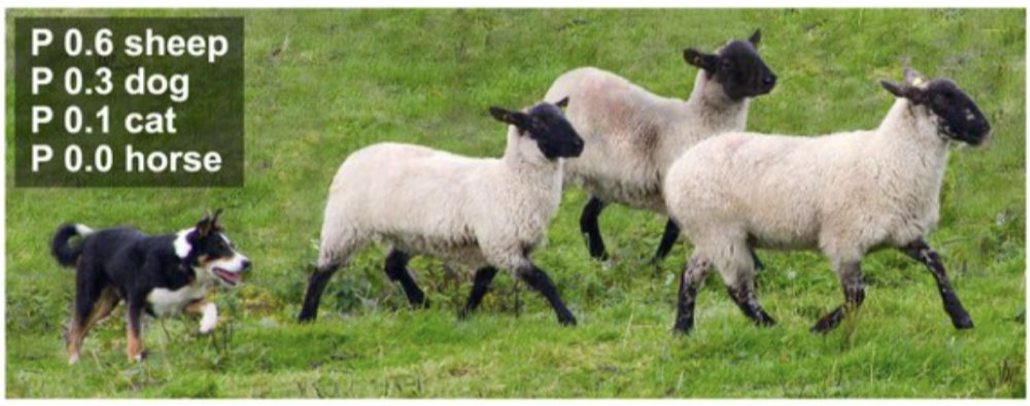

In [1]:
from PIL import Image

image = Image.open("examples/test.png")
image


## Resize the image to 224x224

In [4]:
from PIL import Image
import numpy as np
from typing import List, Tuple, Optional, Union, Iterable, Dict

def rescale(
    image: np.ndarray, scale: float, dtype: np.dtype = np.float32
) -> np.ndarray:
    rescaled_image = image * scale
    rescaled_image = rescaled_image.astype(dtype)
    return rescaled_image


def resize(
    image: Image,
    size: Tuple[int, int],
    resample: Image.Resampling = None,
    reducing_gap: Optional[int] = None,
) -> np.ndarray:
    height, width = size
    resized_image = image.resize(
        (width, height), resample=resample, reducing_gap=reducing_gap
    )
    return resized_image


def normalize(
    image: np.ndarray,
    mean: Union[float, Iterable[float]],
    std: Union[float, Iterable[float]],
) -> np.ndarray:
    mean = np.array(mean, dtype=image.dtype)
    std = np.array(std, dtype=image.dtype)
    image = (image - mean) / std
    return image


def process_images(
    images: List[Image.Image],
    size: Dict[str, int] = None,
    resample: Image.Resampling = None,
    rescale_factor: float = None,
    image_mean: Optional[Union[float, List[float]]] = None,
    image_std: Optional[Union[float, List[float]]] = None,
) -> List[np.ndarray]:
    height, width = size[0], size[1]
    images = [
        resize(image=image, size=(height, width), resample=resample) for image in images
    ]
    images = [np.array(image) for image in images]
    # Rescale the pixel values to be in the range [0, 1]
    images = [rescale(image, scale=rescale_factor) for image in images]
    # Normalize the images to have mean 0 and standard deviation 1
    images = [normalize(image, mean=image_mean, std=image_std) for image in images]
    # Move the channel dimension to the first dimension as the model expects images in the format [Channel, Height, Width]
    images = [image.transpose(2, 0, 1) for image in images]

    return images


In [2]:
import torch
import numpy as np
from PIL import Image
from typing import Dict, List, Optional, Tuple, Iterable, Union
import torchvision.transforms as T

def preprocess_single_image(image, size=(224, 224), mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    # Support PIL.Image or str(path)
    if isinstance(image, str):
        image = Image.open(image).convert('RGB')
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image).convert('RGB')
    elif not isinstance(image, Image.Image):
        raise ValueError("Unsupported image type")
    
    # Resize
    transform = T.Compose([
        T.Resize(size, antialias=True),
        T.ToTensor(),  # [C, H, W] Tensor
        T.Normalize(mean=mean, std=std)
    ])
    image_tensor = transform(image).unsqueeze(0)  # [1, 3, H, W]
    
    return image_tensor

In [3]:
test_image_tensor = preprocess_single_image("examples/test.png")
print(test_image_tensor.shape)

torch.Size([1, 3, 224, 224])


## Siglip Embedding

In [7]:

import torch
import torch.nn as nn
from src.vision.siglip_config import SiglipConfig


class SiglipVisionEmbeddings(nn.Module):
    

    def __init__(self, config: SiglipConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=config.hidden_size,
            kernel_size=config.patch_size,
            stride=config.patch_size,
            padding="valid",  # no padding added
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False,
        )

    def forward(self, pixel_values):
        patch_embeds = self.patch_embedding(
            # (batch_size, num_channels, image_size, image_size)
            pixel_values
        )  # (batch_size, embed_dim, num_patches_h, num_patches_w) | Also: num_patches_h * num_patches_w = num_patches
        embeddings = patch_embeds.flatten(2)  # (batch_size, embed_dim, num_patches)
        embeddings = embeddings.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings


class SiglipAttention(nn.Module):
    def __init__(self, config: SiglipConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.dropout = config.attention_dropout
        self.head_dim = self.embed_dim // config.num_attention_heads

        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        # (batch_size, num_patches, embed_dim)
        batch_size, num_patches, _ = x.size()
        # (batch_size, num_patches, embed_dim) => (batch_size, num_heads, num_patches, head_dim)
        query = (
            self.q_proj(x)
            .view(batch_size, num_patches, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )
        key = (
            self.k_proj(x)
            .view(batch_size, num_patches, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )
        values = (
            self.v_proj(x)
            .view(batch_size, num_patches, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )
        attn_weights = torch.matmul(query, key.transpose(-2, -1)) / self.head_dim**0.5

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        attn_weights = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )
        attn_output = torch.matmul(attn_weights, values)
        attn_output = attn_output.transpose(
            1, 2
        ).contiguous()  # (batch_size, num_patches, num_heads, head_dim)
        attn_output = attn_output.view(
            batch_size, num_patches, self.embed_dim
        )  # (batch_size, num_patches, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class MLP(nn.Module):
    def __init__(self, config: SiglipConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size

        self.fc1 = nn.Linear(self.hidden_size, self.intermediate_size)
        self.fc2 = nn.Linear(self.intermediate_size, self.hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.gelu(x, approximate="tanh")
        x = self.fc2(x)
        return x


class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size

        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = MLP(config)
        self.self_attn = SiglipAttention(config)

    def forward(self, x):
        # (batch_size, num_patches, embed_dim)
        residual = x
        x = self.layer_norm1(x)
        x, _ = self.self_attn(x)
        x = residual + x

        residual = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = residual + x
        # (batch_size, num_patches, embed_dim)
        return x


class SiglipEncoder(nn.Module):

    def __init__(self, config: SiglipConfig):
        super().__init__()
        self.config = config
        self.num_layers = config.num_hidden_layers
        self.layers = nn.ModuleList(
            [SiglipEncoderLayer(config) for _ in range(self.num_layers)]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class SiglipVisionTransformer(nn.Module):

    def __init__(self, config: SiglipConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:

        x = self.embeddings(pixel_values)
        x = self.encoder(x)
        x = self.post_layernorm(x)
        return x


class SiglipVisionModel(nn.Module):

    def __init__(self, config: SiglipConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values):
        # pixel_values:(batch_size, num_channels, image_size, image_size) => (batch_size, num_patches, embed_dim)
        return self.vision_model(pixel_values=pixel_values)


In [8]:
class SiglipConfig:

    def __init__(
        self,
        hidden_size=768,
        intermediate_size=3072,
        num_hidden_layers=12,
        num_attention_heads=12,
        num_channels=3,
        image_size=224,
        patch_size=16,
        layer_norm_eps=1e-6,
        attention_dropout=0.0,
        num_image_tokens: int = None,
        **kwargs,
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_channels = num_channels
        self.patch_size = patch_size
        self.image_size = image_size
        self.attention_dropout = attention_dropout
        self.layer_norm_eps = layer_norm_eps
        self.num_image_tokens = num_image_tokens



In [9]:
test_vision_model = SiglipVisionModel(SiglipConfig())

test_embedding = test_vision_model(test_image_tensor)

print(test_embedding.shape)

torch.Size([1, 196, 768])


## Prompt

In [11]:
def add_image_tokens_to_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    # The input text is tokenized normally.
    # A <bos> token is added at the beginning, and an additional newline token (\n) is appended.
    # This newline token is an essential part of the input prompt the model was trained with, so adding it explicitly ensures it's always there.
    # The tokenized text is also prefixed with a fixed number of <image> tokens.
    # Unlike in the PaliGemma paper, the Hugging Face code doesn't tokenize \n separately.
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"


In [12]:
bos_token = "<bos>"
image_seq_len = 196
IMAGE_TOKEN = "<image>"
prompt = "Describe the image."

test_prompt = add_image_tokens_to_prompt(prompt, bos_token, image_seq_len, IMAGE_TOKEN)
print(test_prompt)

<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image

In [16]:
import torch
import numpy as np
from PIL import Image
from typing import Dict, List, Optional, Tuple, Iterable, Union
import torchvision.transforms as T


################################### Constants ###################################

IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]  # From HF code
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]  # From HF code

################################### Utility functions ###################################


def add_image_tokens_to_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    # The input text is tokenized normally.
    # A <bos> token is added at the beginning, and an additional newline token (\n) is appended.
    # This newline token is an essential part of the input prompt the model was trained with, so adding it explicitly ensures it's always there.
    # The tokenized text is also prefixed with a fixed number of <image> tokens.
    # Unlike in the PaliGemma paper, the Hugging Face code doesn't tokenize \n separately.
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"



################################### PaliGemma Processor ###################################


class PaliGemmaProcessor:

    IMAGE_TOKEN = "<image>"

    def __init__(self, tokenizer, num_image_tokens: int, image_size: int):
        super().__init__()
        self.image_seq_length = num_image_tokens
        self.image_size = image_size

        tokens_to_add = {"additional_special_tokens": [self.IMAGE_TOKEN]}
        tokenizer.add_special_tokens(tokens_to_add)
        # Tokens for object segmentation
        EXTRA_TOKENS = [
            f"<loc{i:04d}>" for i in range(1024)
        ]  # These tokens are used for object detection (bounding boxes)
        EXTRA_TOKENS += [f"<seg{i:03d}>" for i in range(128)]
        tokenizer.add_tokens(EXTRA_TOKENS)
        self.image_token_id = tokenizer.convert_tokens_to_ids(self.IMAGE_TOKEN)
        # The tokenizer will not automatically prepend a BOS token or append an EOS token when encoding text.
        tokenizer.add_bos_token = False
        tokenizer.add_eos_token = False

        self.tokenizer = tokenizer

    def __call__(
        self,
        text: str,
        image: Image.Image,
        padding: str = "longest",
        truncation: bool = False,
    ) -> dict:

        pixel_values = preprocess_single_image(
            image,
            size=(self.image_size, self.image_size),
            mean=IMAGENET_STANDARD_MEAN,
            std=IMAGENET_STANDARD_STD,
        )

        # The image tokens act as placeholders and will be later replaced by the image embeddings.
        input_strings = add_image_tokens_to_prompt(
                prefix_prompt=text,
                bos_token=self.tokenizer.bos_token,
                image_seq_len=self.image_seq_length,
                image_token=self.IMAGE_TOKEN,
            )
        

        # Returns the input_ids and attention_mask as PyTorch tensors
        # The attention mask is only 1s as we don't use padding
        # The model has been trained with a maximum sequence length of 128
        inputs = self.tokenizer(
            input_strings,
            return_tensors="pt",
            padding=padding,
            truncation=truncation,
        )

        return_data = {"pixel_values": pixel_values, **inputs}

        # we return the preprocessed image tensor and the tokenized input with the <image> placeholders, BOS token, prefix prompt and the separator.
        return return_data


In [24]:
from transformers import AutoTokenizer

tokenizer=AutoTokenizer.from_pretrained("paligemma2-3b-mix-448")

inputs = tokenizer(
            "describe",
            return_tensors="pt",
            padding="longest",
            truncation=False,
        )

print(inputs)

{'input_ids': tensor([[15019]]), 'attention_mask': tensor([[1]])}


In [25]:
test_processor = PaliGemmaProcessor(
    tokenizer=AutoTokenizer.from_pretrained("paligemma2-3b-mix-224"),
    num_image_tokens=196,
    image_size=224,
)

test_input = test_processor(
    text="describe",
    image="examples/parrots.png",
    padding="longest",
    truncation=False,
)

print("--- Processor Output ---")
print("Keys:", test_input.keys())
print("\n")


--- Processor Output ---
Keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask'])




In [26]:
test_pixel_values = test_input["pixel_values"]
print(f"Pixel Values Shape: {test_pixel_values.shape}")
print(f"Pixel Values Type: {test_pixel_values.dtype}")
print("说明: 这是图像被缩放、标准化后输入给视觉编码器的张量。形状应为 [1, 3, 224, 224]。")
print("\n")

Pixel Values Shape: torch.Size([1, 3, 224, 224])
Pixel Values Type: torch.float32
说明: 这是图像被缩放、标准化后输入给视觉编码器的张量。形状应为 [1, 3, 224, 224]。




In [28]:
# 检查处理后的文本张量
test_input_ids = test_input["input_ids"]
print(f"Input IDs Shape: {test_input_ids.shape}")
print(f"Input IDs: {test_input_ids}")
print("说明: 这是文本被转换成的数字ID序列。")
print("\n")


Input IDs Shape: torch.Size([1, 199])
Input IDs: tensor([[257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257

In [31]:
# 将 input_ids 解码回文本，直观地检查格式是否正确
test_decoded_text = test_processor.tokenizer.decode(test_input_ids[0], skip_special_tokens=False)
print(f"Decoded Text:\n'{test_decoded_text}'")
print("\n说明: 这是模型实际看到的完整输入序列。")
print("您应该会看到：")
print("1. 开头有 196 个 '<image>' token。")
print("2. 接着是 BOS (Beginning of Sentence) token，通常是 '<BOS>'。")
print("3. 然后是您输入的提示 'describe this image'。")
print("4. 最后是一个换行符 '\\n'。")

Decoded Text:
'<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><imag